In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('/Users/connorvoglewede/git-folder/boba')

In [150]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import warnings 
import yaml
import matplotlib.pyplot as plt
import math 

from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import AlphaSelection

import pymc3 as pm
from pymc3 import traceplot


import boba.preprocessing as pp
import boba.modeling as m

warnings.filterwarnings("ignore")


In [6]:
pd.set_option('max_rows',50)
pd.set_option('max_columns',400)

In [7]:
season = 2021

per_metric_h = 'PA' 
pt_metric_h = 'PA'      
counting_stats_h = ['HR','R','RBI','WAR','SB','CS']
rate_stats_h = ['AVG','OBP','SLG','BABIP','BB%','K%','wOBA']
model_targets_h = rate_stats_h + [c+'_per_'+per_metric_h for c in counting_stats_h]  

per_metric_sp = 'GS' 
pt_metric_sp = 'IP'      
counting_stats_sp = ['ShO','CG','W','WAR']
rate_stats_sp = ['ERA','BB_per_9','K_per_9','OBP','SLG']
model_targets_sp = rate_stats_sp + [c+'_per_'+per_metric_sp for c in counting_stats_sp]  

per_metric_rp = 'G' 
pt_metric_rp = 'IP'      
counting_stats_rp = ['SV','HLD','WAR']
rate_stats_rp = ['ERA','BB_per_9','K_per_9','OBP','SLG']
model_targets_rp = rate_stats_rp + [c+'_per_'+per_metric_rp for c in counting_stats_rp] 


In [197]:
modeling_df_h = pd.read_csv('data/processed/hitters/'+str(season)+'/modeling.csv',index_col=0)
modeling_df_sp = pd.read_csv('data/processed/SP/'+str(season)+'/modeling.csv',index_col=0)
modeling_df_rp = pd.read_csv('data/processed/RP/'+str(season)+'/modeling.csv',index_col=0)

In [198]:
rel_cols_h = m.run_corr_analysis(modeling_df = modeling_df_h, season=season, position_group='hitters', model_targets=model_targets_h, counting_stats = counting_stats_h)
rel_cols_sp = m.run_corr_analysis(modeling_df = modeling_df_sp, season=season, position_group='SP', model_targets=model_targets_sp, counting_stats = counting_stats_sp)
rel_cols_rp = m.run_corr_analysis(modeling_df = modeling_df_rp, season=season, position_group='RP', model_targets=model_targets_rp, counting_stats = counting_stats_rp)

100%|██████████| 8/8 [00:11<00:00,  1.48s/it]


In [241]:
position_group = 'hitters'
target = 'OBP'
pt_metric = 'PA'
knn = 100

In [289]:
model_df = m.isolate_relevant_columns(modeling_df_h, position_group, target, season)

In [290]:
model_df

,Season,OBP,Age,PA,BB%_1yrago,K%_1yrago,BB/K_1yrago,OBP_1yrago,SLG_1yrago,AVG_1yrago,WAR_1yrago,R_1yrago,SB_1yrago,CS_1yrago,BABIP_1yrago,HR/FB_1yrago,Swing%_1yrago,F-Strike%_1yrago,Hard%_1yrago,in_zone_percent_1yrago,out_zone_percent_1yrago,oz_swing_percent_1yrago,iz_contact_percent_1yrago,z_swing_miss_percent_1yrago,linedrives_percent_1yrago,poorlyweak_percent_1yrago,solidcontact_percent_1yrago,out_zone_swing_1yrago,in_zone_swing_miss_1yrago,pitch_count_offspeed_1yrago,k_percent_1yrago,bb_percent_1yrago,barrel_1yrago,sweet_spot_percent_1yrago,ba_1yrago,xbacon_1yrago,babip_1yrago,obp_1yrago,slg_1yrago,xobp_1yrago,xslg_1yrago,wobacon_1yrago,BB%_2yrago,K%_2yrago,BB/K_2yrago,OBP_2yrago,SLG_2yrago,AVG_2yrago,ISO_2yrago,WAR_2yrago,R_2yrago,SB_2yrago,CS_2yrago,BABIP_2yrago,IFFB%_2yrago,HR/FB_2yrago,O-Swing%_2yrago,Swing%_2yrago,Zone%_2yrago,F-Strike%_2yrago,SwStr%_2yrago,Soft%_2yrago,Hard%_2yrago,in_zone_percent_2yrago,out_zone_percent_2yrago,edge_percent_2yrago,oz_contact_percent_2yrago,f_strike_percent_2yrago,meatball_percent_2yrago,oz_swing_miss_percent_2yrago,popups_percent_2yrago,linedrives_percent_2yrago,groundballs_percent_2yrago,poorlytopped_percent_2yrago,flareburner_percent_2yrago,solidcontact_percent_2yrago,out_zone_swing_2yrago,in_zone_swing_miss_2yrago,pitch_count_offspeed_2yrago,k_percent_2yrago,bb_percent_2yrago,barrel_2yrago,barrel_batted_rate_2yrago,exit_velocity_avg_2yrago,sweet_spot_percent_2yrago,hard_hit_percent_2yrago,ba_2yrago,xba_2yrago,xbacon_2yrago,babip_2yrago,obp_2yrago,slg_2yrago,xobp_2yrago,xslg_2yrago,iso_2yrago,wobacon_2yrago,BB%_3yrago,BB/K_3yrago,OBP_3yrago,SLG_3yrago,AVG_3yrago,ISO_3yrago,WAR_3yrago,RBI_3yrago,SB_3yrago,CS_3yrago,F-Strike%_3yrago,Soft%_3yrago,Hard%_3yrago,in_zone_percent_3yrago,out_zone_percent_3yrago,oz_swing_percent_3yrago,iz_contact_percent_3yrago,whiff_percent_3yrago,f_strike_percent_3yrago,swing_percent_3yrago,z_swing_miss_percent_3yrago,popups_percent_3yrago,flyballs_percent_3yrago,linedrives_percent_3yrago,groundballs_percent_3yrago,poorlyweak_percent_3yrago,poorlytopped_percent_3yrago,flareburner_percent_3yrago,solidcontact_percent_3yrago,hr_flyballs_percent_3yrago,in_zone_swing_miss_3yrago,out_zone_swing_miss_3yrago,pitch_count_fastball_3yrago,pitch_count_offspeed_3yrago,bb_percent_3yrago,barrel_3yrago,barrel_batted_rate_3yrago,exit_velocity_avg_3yrago,sweet_spot_percent_3yrago,ba_3yrago,xba_3yrago,bacon_3yrago,xbacon_3yrago,obp_3yrago,slg_3yrago,xobp_3yrago,xslg_3yrago,iso_3yrago,career_PA,career_HR,career_WAR,career_AVG,career_OBP,career_BB%,career_O-Swing%,career_Soft%,career_barrel_batted_rate,career_exit_velocity_avg,career_sweet_spot_percent,career_hard_hit_percent,career_xba,career_xwoba,career_xwobacon,career_wobacon,H_w3yr,BB/K_w3yr,OPS_w3yr,ISO_w3yr,WAR_w3yr,HR_w3yr,SB_w3yr,CS_w3yr,BABIP_w3yr,HR/FB_w3yr,Swing%_w3yr,Zone%_w3yr,F-Strike%_w3yr,SwStr%_w3yr,Hard%_w3yr,linedrives_percent_1yrDiff,poorlyweak_percent_1yrDiff,flareburner_percent_1yrDiff,solidcontact_percent_w3yr,hr_flyballs_percent_w3yr,in_zone_swing_miss_w3yr,pitch_count_fastball_w3yr,bb_percent_w3yr,barrel_w3yr,xiso_w3yr,woba_w3yr
24458,2015.0,0.460,22.0,654.0,0.096,0.263,0.37,0.344,0.423,0.273,1.6,41.0,2.0,2.0,0.352,0.155,0.509,0.610,0.302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.123,0.189,0.65,0.368,0.486,0.274,0.212,4.1,71.0,11.0,4.0,0.306,0.063,0.180,0.332,0.484,0.366,0.575,0.110,0.154,0.356,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.094,0.47,0.340,0.477,0.270,0.206,4.4,59.0,18.0,6.0,0.590,0.122,0.301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1489.0,55.0,10.1,0.272131,0.350407,0.104210,0.343048,0.147802,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,121.920752,0.503553,0.816351,0.193412,3.557085,18.944929,11.419073,4.271323,0.319807,0.166151,0.496245,0.377721,0.590299,0.120635

In [281]:
model_df = model_df.drop(pt_metric,axis=1)

In [243]:
for x in [e for e in model_df.columns.tolist() if e not in ['Season']+[pt_metric]+[target]]:
    model_df[x+'_I_PT'] = model_df[pt_metric]*model_df[x]

Options for treating training data
- all data
- remove low PT cases
- standardize
- interaction effects
- sample

In [282]:
X_train_raw, X_test_raw, y_train, y_test = m.evaluation_split(model_df,target,season)

Split model Dataframe into pre-2020 data


In [283]:
X_train, X_test = m.preprocessing_pipeline(X_train_raw, X_test_raw, target, knn)

Fit Preprocessing Steps to X_train and transform X_test


In [284]:
# sample_df = pd.concat([X_train,y_train],axis=1)
# sample_df = sample_df.sample(n=5000,replace=True,weights=X_train_raw['PA'], random_state=88)
# X_train_sampled = sample_df.drop([target],axis=1)
# y_train_sampled = sample_df[[target]]

training score: 0.09382232527006995
test score:  0.09886452349977172
number of features used:  12


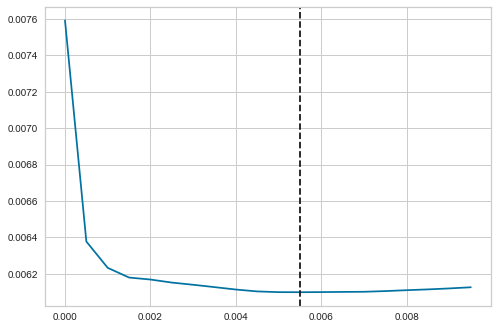

In [285]:
alphas = list(np.arange(0,.01,.0005))

x_choice = X_train.copy()
y_choice = y_train.copy()

lasso_cv = LassoCV(alphas=alphas)
visualizer = AlphaSelection(lasso_cv)
visualizer.fit(x_choice, y_choice)
alpha_val = lasso_cv.alpha_
lasso = Lasso(alpha=alpha_val)
lasso.fit(x_choice, y_choice)
train_score=lasso.score(x_choice, y_choice)
test_score=lasso.score(X_test,y_test)
coeff_used = np.sum(lasso.coef_!=0)
print("training score:", train_score)
print("test score: ", test_score)
print("number of features used: ", coeff_used)

In [286]:
rel_cols = rel_cols_h[target]
lasso_cols = X_train.iloc[:,lasso.coef_!=0].columns.tolist()
lasso_df = X_train.iloc[:,lasso.coef_!=0]

In [287]:
corr_df = pd.DataFrame(columns = ['col','corr'])
for x in lasso_df.columns.tolist():
    corr = X_train[x].corr(y_train[target])
    corr_df = corr_df.append({'col': x, 'corr': corr}, ignore_index=True)
corr_df = corr_df.sort_values('corr',ascending=False)
corr_df.head(50)
# corr_cols = corr_df['col'][0:7]
# corr_cols

,col,corr
11,WAR_w3yr,0.283283
2,R_1yrago,0.273723
3,xobp_1yrago,0.222340
1,OBP_1yrago,0.203598
6,xobp_2yrago,0.198567
0,BB/K_1yrago,0.193118
9,career_exit_velocity_avg,0.191473
10,BB/K_w3yr,0.189168
8,career_BB%,0.166511
7,BB/K_3yrago,0.161280


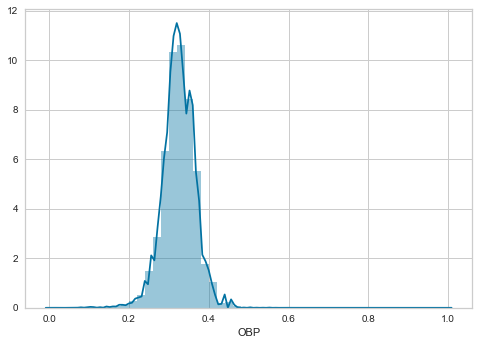

In [214]:
sns.distplot(y_train[target])

In [ ]:
formula = 'SUC ~ ' + ' + '.join(['%s' % variable for variable in X_train.columns[1:]])
print(formula)

# Context for the model
with pm.Model() as normal_model:
    # The prior for the model parameters will be a normal distribution
    family = pm.glm.families.Normal()

    # Creating the model requires a formula and data (and optionally a family)
    pm.GLM.from_formula(formula, data = X_train, family = family)

    # Perform Markov Chain Monte Carlo sampling
    normal_trace = pm.sample(draws=2000, chains = 2, tune = 500)

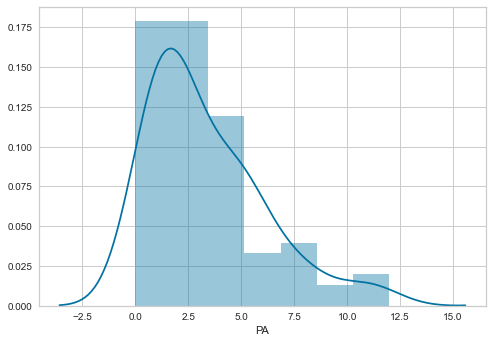

In [178]:
sns.distplot(modeling_df_h[modeling_df_h['OBP']==0]['PA'])

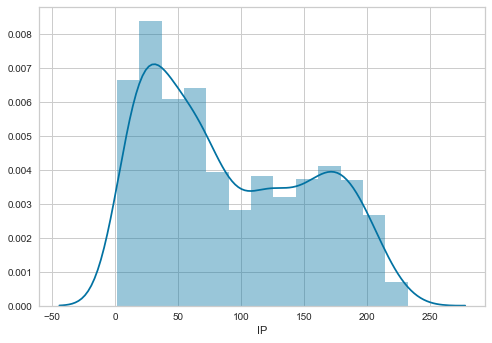

In [179]:
sns.distplot(modeling_df_sp['IP'])